<a href="https://colab.research.google.com/github/aneeshcheriank/approaching-any-machine-learning-problem/blob/main/Gan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[URL of this notebook](https://www.tensorflow.org/tutorials/generative/dcgan)

In [ ]:
import tensorflow as tf
import glob # check
import imageio # check
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = ((x_train - 127.5)/127.5)\
.reshape((-1, 28, 28, 1))

BUFFER_SIZE = 6000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)\
.shuffle(BUFFER_SIZE)\
.batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
  model = tf.keras.Sequential([
     layers.Dense(7*7*256, use_bias=False, input_shape=(100, )),
     layers.BatchNormalization(),
     layers.LeakyReLU(),

     layers.Reshape((7, 7, 256)),

     layers.Convolution2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
     layers.BatchNormalization(),
     layers.LeakyReLU(),
     # output size (None, 7, 7, 128)

     layers.Convolution2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
     layers.BatchNormalization(),
     layers.LeakyReLU(),
     # output size (None, 14, 14, 64)

     layers.Convolution2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])

  return model

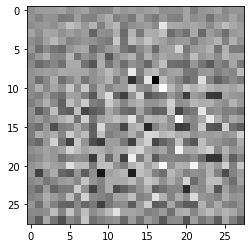

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generator_image = generator(noise, training=False)

plt.imshow(
    np.squeeze(generator_image), cmap='gray'
)

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(1)
  ])

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generator_image)
print(decision)

tf.Tensor([[0.00096873]], shape=(1, 1), dtype=float32)


In [ ]:
# define the optimizer
# defind the loss
corss_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = corss_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeors_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
  # why should we do this? should we do the traditional way?

# generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

- need to optimize the discriminator and the genetrator seperately
  - training is seperate

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [ ]:
## Save Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_losses = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = gen_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimzer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimzer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # producing display for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    # save the model for every 15 epochs
    if (epoch + 1)%15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is ')